In [21]:
import orjson
import json
import msgpack
import numpy as np

In [1]:
import pandas as pd
import numpy as np
import logging

from moonshots.hyperliquid.scraper import Scraper
from moonshots.hyperliquid import HyperliquidAsync
from moonshots.data_utils import xy_group

import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)  
logger.debug('test')

DEBUG:__main__:test


In [3]:
scraper = Scraper()

In [4]:
period = '1m'

In [5]:
candles = await scraper.historical_candles(interval=period)
candles.to_parquet(f'../../data/candles_{period}.parquet')

DEBUG:moonshots.hyperliquid.scraper:Retrieving historical candles for 154 coins with 30 requests per minute.
100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


In [16]:
candles = pd.read_parquet(f'../../data/candles_{period}.parquet')

In [17]:
close_prices = candles['c'].unstack().dropna(how='all').iloc[-5000:]
volume = candles['v'].unstack().dropna(how='all').iloc[-5000:]
close_returns = np.log(close_prices).diff()

In [ ]:
# windows = [5,10,20,40,80,160]
# agg_signal = sum([
#     - (close_prices > close_prices.ewm(w).mean()).astype(int)
#     + (close_prices < close_prices.ewm(w).mean()).astype(int)
#     for w in windows
#     ]) / len(windows) 

In [20]:
w = 100
agg_signal = - (close_prices - close_prices.ewm(w).mean()) / close_prices.ewm(w).std()
agg_signal = agg_signal.subtract(agg_signal.mean(axis=1), axis=0)

In [21]:
(np.sign(agg_signal).diff().abs()==2).apply(lambda s: s[s].index.diff().mean()).mean()

Timedelta('0 days 00:13:14.298998063')

/var/folders/3j/00g9ky7x1bx8xjvxbt1xy4w40000gn/T/ipykernel_31731/685851378.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_return = close_prices.pct_change(13).shift(13)


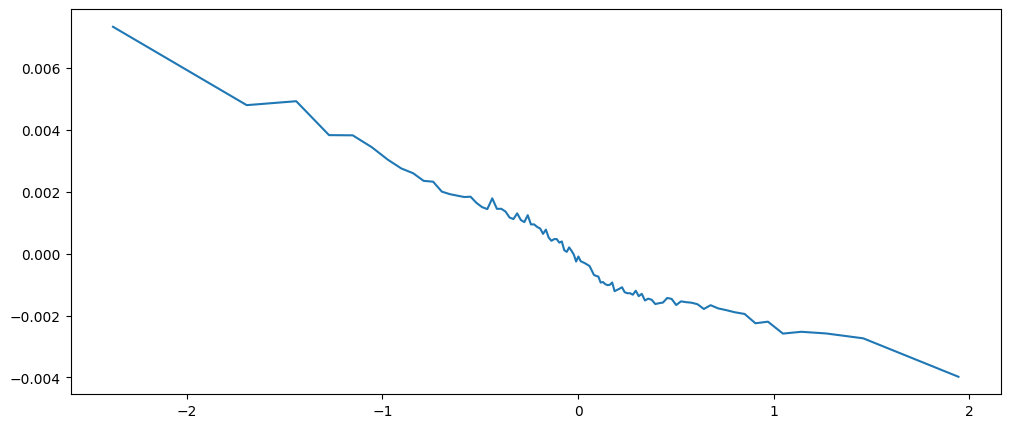

In [22]:
w = 13
forward_return = close_prices.pct_change(13).shift(13)
plt.figure(figsize=(12,5))
plt.plot(*xy_group(agg_signal.stack(), forward_return.stack(), 100))

<Axes: xlabel='t'>

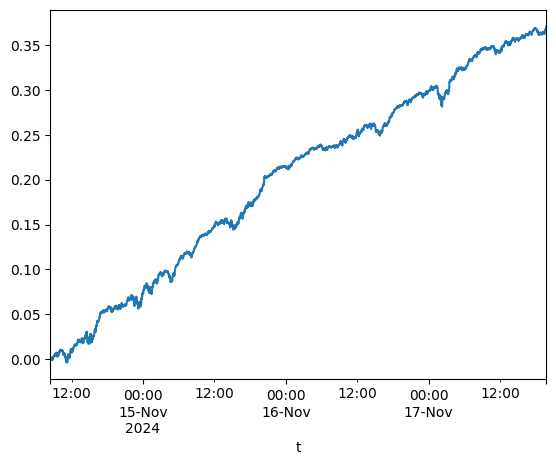

In [23]:
weights = agg_signal.divide(agg_signal.abs().sum(axis=1), axis=0)
(weights.shift().clip(lower=0) * close_returns).sum(axis=1).cumsum().plot()

In [ ]:
import statsmodels.api as sm

# Signal

In [7]:
signal = close_prices.ewm(6).mean() / close_prices.ewm(24).mean() - 1

<Axes: >

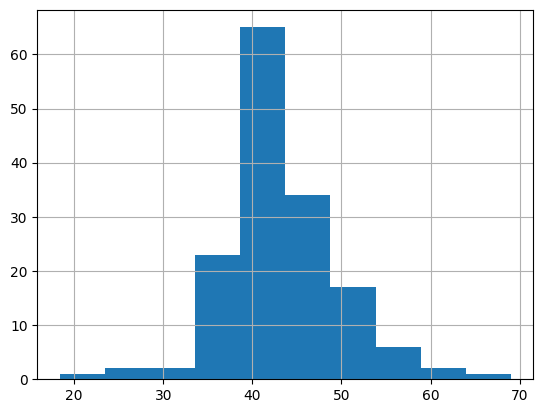

In [8]:
(np.sign(signal).diff().abs()==2).apply(lambda s: s[s].index.diff().mean().total_seconds()/3600).hist()

/var/folders/3j/00g9ky7x1bx8xjvxbt1xy4w40000gn/T/ipykernel_33072/683219329.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  y = close_prices.pct_change(40).shift(-40).stack()


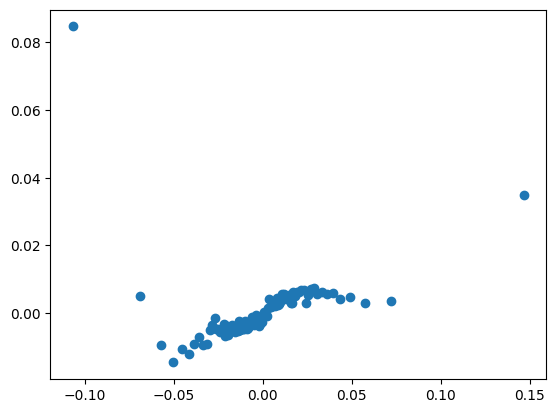

In [9]:
x = signal.stack()
y = close_prices.pct_change(40).shift(-40).stack()

plt.scatter(*xy_group(x, y, 100))

/var/folders/3j/00g9ky7x1bx8xjvxbt1xy4w40000gn/T/ipykernel_33072/3392416007.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (weights.shift() * close_prices.pct_change()).sum(axis=1).cumsum().plot()


<Axes: xlabel='t'>

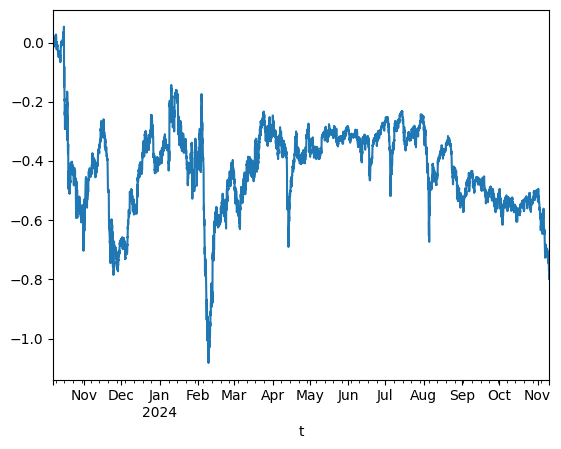

In [10]:
weights = -signal.clip(lower=-0.05, upper=0.05)
weights = weights.divide(weights.abs().sum(axis=1), axis=0)
(weights.shift() * close_prices.pct_change()).sum(axis=1).cumsum().plot()

/var/folders/3j/00g9ky7x1bx8xjvxbt1xy4w40000gn/T/ipykernel_33072/782756954.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (weights.shift() * close_prices.pct_change()).sum(axis=1).cumsum().plot()


<Axes: xlabel='t'>

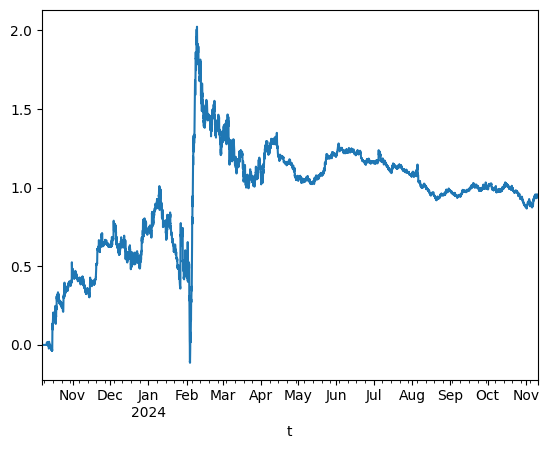

In [11]:
weights = (
    signal.ge(signal.quantile(0.9, axis=1), axis=0).astype(int)
    - signal.le(signal.quantile(0.1, axis=1), axis=0).astype(int)
)
weights = weights.divide(weights.abs().sum(axis=1), axis=0)
(weights.shift() * close_prices.pct_change()).sum(axis=1).cumsum().plot()

# Analysis

In [12]:
close_returns = close_prices.pct_change()

/var/folders/3j/00g9ky7x1bx8xjvxbt1xy4w40000gn/T/ipykernel_33072/872812227.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  close_returns = close_prices.pct_change()


In [13]:
volume = candles['v'].unstack()

In [14]:
close_prices 

s,AAVE,ACE,ADA,AI,ALT,APE,APT,AR,ARB,ARK,...,ZETA,ZK,ZRO,kBONK,kDOGS,kFLOKI,kLUNC,kNEIRO,kPEPE,kSHIB
t,,,,,,,,,,,,,,,,,,,,,
2023-10-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-07 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-07 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-07 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-10 08:00:00,191.97,2.3286,0.57863,0.44205,0.11644,1.1258,11.220,19.427,0.62640,0.53959,...,0.78963,0.14861,3.8654,0.023963,0.73718,0.15440,0.099759,2.8257,0.011611,0.022589
2024-11-10 09:00:00,192.78,2.3606,0.58682,0.44909,0.11900,1.1324,11.172,19.536,0.63560,0.53893,...,0.78329,0.14995,3.8840,0.024492,0.74508,0.15543,0.099942,2.8045,0.011807,0.022725
2024-11-10 10:00:00,192.20,2.3536,0.58537,0.44961,0.11876,1.1449,11.292,19.367,0.63921,0.53878,...,0.78929,0.15175,3.9178,0.024740,0.74435,0.16603,0.100240,2.8018,0.011906,0.023453
